In [406]:
# Holden Higgins
# 1-19-2023
# Cortical systems HW#1

In [407]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from dataclasses import dataclass
plt.rcParams["font.family"] = "serif"


In [408]:
# (1)(c)
trials = 250

sims = []
var_y = []
for seed in range(3):
    g=np.random.default_rng(seed)
    sims.append([])
    for n in range(1,trials):
        xi = g.poisson(lam=100,size=n*trials)
        xi.resize((n,trials))
        xc = g.poisson(lam=5, size=trials)
        # print(np.var(xi+xc))
        sims[-1].append(np.var(np.sum(xi+xc, axis=0)/n))


Text(0.5, 0, 'Number of trials')

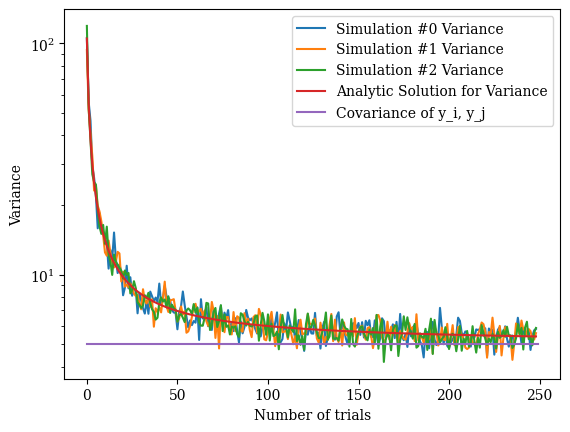

In [409]:
# (1)(c)
analytic_var_y = []
def calc_var_y(n,v,cov):
    return v* (1/n + (cov/v)*(n-1)/n)

v=105
co=5
for n in range(1,trials):
    analytic_var_y.append(calc_var_y(n,v,co))

for seed in range(3):
    plt.plot(sims[seed], label =f"Simulation #{seed} Variance" )
plt.plot(analytic_var_y, label="Analytic Solution for Variance")
plt.plot([co]*trials, label="Covariance of y_i, y_j")
plt.yscale("log")
plt.legend()
plt.ylabel("Variance")
plt.xlabel("Number of trials")

In [410]:
# (2)(c)

def hazard(lam, t_rel, t_abs):
    return lambda t: lam*(1-math.e**((t_abs-t)/t_rel))*(t>t_abs)

def rho(lam, t_rel, t_abs):
    return lambda t: lam*(1-math.e**((t_abs-t)/t_rel))*(t>t_abs)*(math.e**(-lam*(t+(t/t_rel)*math.e**(-t/t_rel))))

In [411]:
# (2)(c)(i)
def sim_rho(rho_conf, steps, timescale):
    r=rho(*rho_conf)
    h=hazard(*rho_conf)
    time_vals = np.arange(0, steps*timescale, timescale)
    rho_vals = np.zeros(steps)
    haz_vals = np.zeros(steps)
    
    for step in range(steps):
        t=step*timescale
        rho_vals[step]=r(t)
        haz_vals[step]=h(t)
    return time_vals, rho_vals, haz_vals

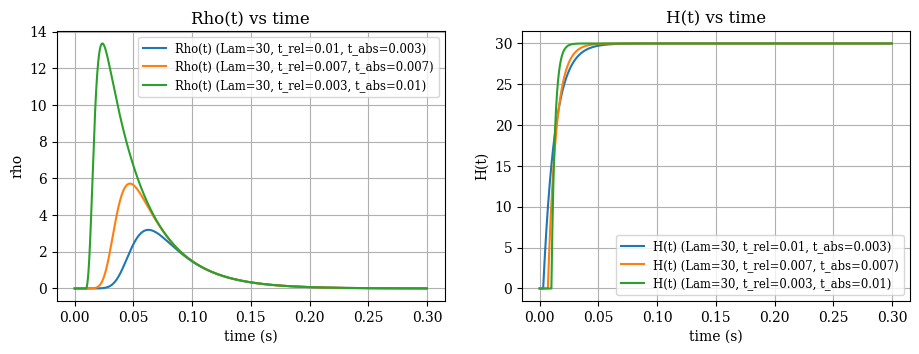

In [412]:
# 2(c)(i)
timescale = .0001
total_time = .3
steps = int(total_time/timescale)
lam = 30

rho_confs=[
    (lam, .01, .003),
    (lam, .007, .007),
    (lam, .003, .01), 
]

fig, ax = plt.subplots(1,2, figsize=(11,3.5))
for rho_conf in rho_confs:
    time_vals, rho_vals, haz_vals = sim_rho(rho_conf, steps, timescale)
    ax[0].plot(time_vals, rho_vals, label="Rho(t) (Lam={}, t_rel={}, t_abs={})".format(*rho_conf))
    ax[1].plot(time_vals, haz_vals, label="H(t) (Lam={}, t_rel={}, t_abs={})".format(*rho_conf))
    
ax[0].set_title("Rho(t) vs time")
ax[1].set_title("H(t) vs time")
ax[0].set_ylabel("rho")
ax[1].set_ylabel("H(t)")
ax[0].set_xlabel("time (s)")
ax[1].set_xlabel("time (s)")
ax[0].grid()
ax[1].grid()
ax[0].legend(fontsize="small")
ax[1].legend(fontsize="small")

In [413]:
# (2)(c)(ii)

def sim_interspikes_hazard(haz_conf, steps, timescale):
    h=hazard(*haz_conf)
    all_isi = []
    t=0
    for step in range(steps):
        if random.random() < h(t):
            all_isi.append(t)
            t=0
        else:
            t+=timescale
            
    return all_isi


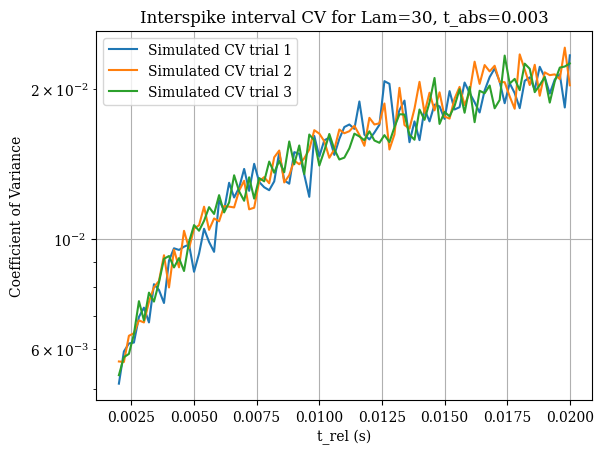

In [414]:
# (2)(c)(ii)
timescale = .00002
total_time = .3
steps = int(total_time/timescale)
lam = 30
t_abs = .003

t_rel_vals = np.arange (.002, .02001, .0002)
isi_std = np.zeros(t_rel_vals.size)
isi_CVs = np.zeros(t_rel_vals.size)

for trial in range(3):
    for idx, t_rel in enumerate(t_rel_vals):
        interspikes = sim_interspikes_hazard((lam, t_rel, t_abs), steps, timescale)
        isi_std[idx] = np.std(interspikes)
        isi_CVs[idx] = np.std(interspikes)/np.mean(interspikes)
    plt.plot(t_rel_vals, isi_CVs, label=f"Simulated CV trial {trial+1}")

plt.yscale("log")
plt.title("Interspike interval CV for Lam={}, t_abs={}".format(lam,t_abs))
plt.xlabel("t_rel (s)")
plt.ylabel("Coefficient of Variance")
plt.grid()
plt.legend()

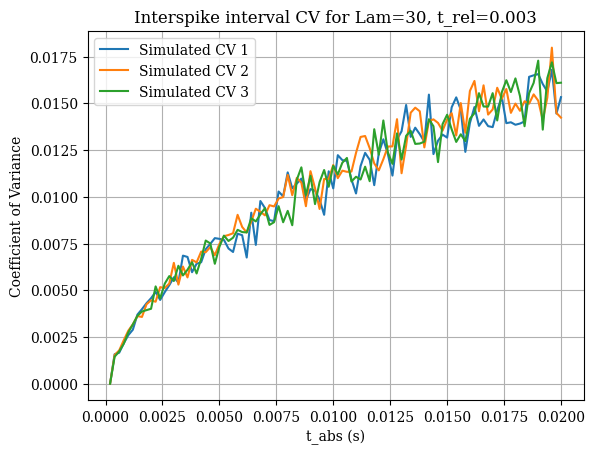

In [415]:
# (2)(c)(ii) (continued)
timescale = .00001
total_time = .3
steps = int(total_time/timescale)
lam = 30
t_rel = .003

t_abs_vals = np.arange (.0002, .02001, .0002)
isi_std = np.zeros(t_abs_vals.size)
isi_CVs = np.zeros(t_abs_vals.size)

for trial in range(3):
    for idx, t_abs in enumerate(t_abs_vals):
        interspikes = sim_interspikes((lam, t_abs, t_rel), steps, timescale)
        isi_std[idx] = np.std(interspikes)
        isi_CVs[idx] = np.std(interspikes)/np.mean(interspikes)
    plt.plot(t_abs_vals, isi_CVs, label=f"Simulated CV {trial+1}")

plt.title("Interspike interval CV for Lam={}, t_rel={}".format(lam,t_rel))
plt.xlabel("t_abs (s)")
plt.ylabel("Coefficient of Variance")
plt.grid()
plt.legend()

In [416]:
# (3)(b)
@dataclass
class Integrator:
    """class for integrating current across firing times"""
    lam: float # Hz
    a: float # uA/cm^2
    tau_1: float # s
    tau_2: float # s
    firing_times: list 
    def current(self, t: float) -> float:
        if len(self.firing_times)>0 and t<self.firing_times[-1]:
            raise ValueError("time t must be after all firing times")
        x = 0
        for firing_time in self.firing_times[::-1]:
            x_ft = math.e**((firing_time-t)/self.tau_1)-math.e**((firing_time-t)/self.tau_2)
            x += x_ft
            if x_ft<x*.01:
                break
        return self.a * x

trial:0 done in 1.2036628723144531, I_net = -0.7046775639952452
trial:1 done in 1.2380914688110352, I_net = 0.017343243206468184
trial:2 done in 1.1464917659759521, I_net = -1.8190012995137728


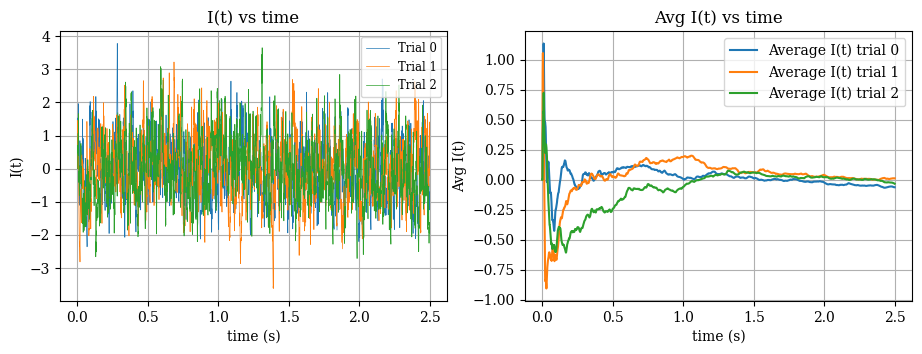

In [417]:
# (3)(b)
timescale = .0005
total_time = 2.5
steps = int(total_time/timescale)
timesteps = np.arange(0,total_time, timescale)

fig, ax = plt.subplots(1,2, figsize=(11,3.5))
for trial in range(3):

    I_net_vals = []
    I_avg_vals = []
    I_E = Integrator(lam = 500, a = 1, tau_1 = .004, tau_2 = .0004, firing_times = [])
    I_I = Integrator(lam = 500, a = (-36)/42.5, tau_1 = .006, tau_2 = .00175, firing_times = [])

    start = time.time()
    for t in timesteps:
        I_net = 0
        for I in [I_E, I_I]:
            if I.lam*timescale > random.random():
                I.firing_times.append(t)
        
            I_net += I.current(t)
            
        I_net_vals.append(I_net)
        I_avg_vals.append(np.average(I_net_vals))
        
    ax[0].plot(timesteps, I_net_vals, label=f"Trial {trial}", linewidth=.5)
    ax[1].plot(timesteps, I_avg_vals, label=f"Average I(t) trial {trial}")
    print(f"trial:{trial} done in {time.time()-start}, I_net = {I_net}")

for i in (0,1):
    ax[i].set_xlabel("time (s)")
    ax[i].legend(fontsize="small")
    ax[i].grid()

ax[0].set_title("I(t) vs time")
ax[1].set_title("Avg I(t) vs time")
ax[0].set_ylabel("I(t)")
ax[1].set_ylabel("Avg I(t)")
plt.legend()

trial:0 done in 1.6314845085144043, I_net = 0.6068577292838886
trial:1 done in 1.7841401100158691, I_net = 0.5613272242830452
trial:2 done in 1.6105823516845703, I_net = 0.1191689683686733


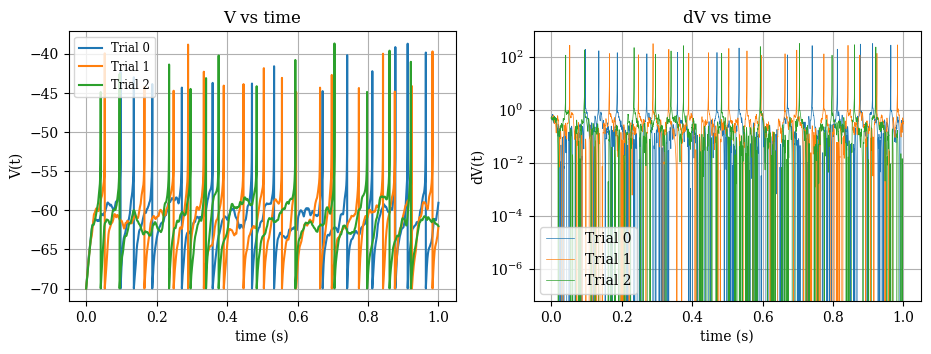

In [418]:
# (3)(c)

timescale = .00002
total_time = 1
steps = int(total_time/timescale)
timesteps = np.arange(0,total_time, timescale)

C = 1 # uF/cm^2
g_L = .1 # mS/cm^2
V_L = -65 # mV
V_T = -60 # mV 
V_reset = -70 # mV
V_peak = -45 # mV
delta = 2 # mV

fig, ax = plt.subplots(1,2, figsize=(11,3.5))
for trial in range(3):
    start = time.time()

    dV_vals = []
    V_vals = []
    I_E = Integrator(lam = 500, a = .2, tau_1 = .004, tau_2 = .0004, firing_times = [])
    I_I = Integrator(lam = 500, a = 0, tau_1 = .006, tau_2 = .00175, firing_times = [])
    
    V = V_reset
    for t in timesteps:
        if V > V_peak:
            V = V_reset
        dV = 0
        I_net = 0
        for I in [I_E, I_I]:
            I_net += I.current(t)
            if I.lam*timescale > random.random():
                I.firing_times.append(t)
        
        phi = g_L * delta * math.e ** ((V-V_T)/delta)
        dV = -g_L * (V - V_L) + phi + I_net
            
        V += dV * timescale * 1000
        
        V_vals.append(V)
        dV_vals.append(dV)                               
        
    ax[0].plot(timesteps, V_vals, label=f"Trial {trial}")
    ax[1].plot(timesteps, dV_vals, label=f"Trial {trial}", linewidth=.5)
    print(f"trial:{trial} done in {time.time()-start}, I_net = {I_net}")

for i in (0,1):
    ax[i].set_xlabel("time (s)")
    ax[i].legend(fontsize="small")
    ax[i].grid()

ax[0].set_title("V vs time")
ax[1].set_title("dV vs time")
ax[0].set_ylabel("V(t)")
ax[1].set_ylabel("dV(t)")
ax[1].set_yscale("log")
plt.legend()

In [419]:
# (3)(c) (continued)
timescale = .0002
total_time = 1
steps = int(total_time/timescale)
timesteps = np.arange(0,total_time, timescale)
spike_counts = []

C = 1 # uF/cm^2
g_L = .1 # mS/cm^2
V_L = -65 # mV
V_T = -60 # mV 
V_reset = -70 # mV
V_peak = -45 # mV
delta = 2 # mV

start = time.time()
for trial in range(1000):
    I_E = Integrator(lam = 500, a = .2, tau_1 = .004, tau_2 = .0004, firing_times = [])
    I_I = Integrator(lam = 500, a = 0, tau_1 = .006, tau_2 = .00175, firing_times = [])
    spikes = np.random.rand(timesteps.size) < 500*timescale
    
    spike_count = 0
    V = V_reset
    for idx, t in enumerate(timesteps):
        dV = 0
        I_net = 0
        if V > V_peak:
            spike_count += 1
            V = V_reset
        
        for I in [I_E, I_I]:
            I_net += I.current(t)
            if spikes[idx]:
                I.firing_times.append(t)
        
        phi = g_L * delta * math.e ** ((V-V_T)/delta)
        dV = -g_L * (V - V_L) + phi + I_net
            
        V += dV * timescale * 1000
                
    spike_counts.append(spike_count)
    if trial % 100 == 0:
        print(f"trial:{trial} done in {time.time()-start}, spike_count = {spike_count}")


trial:0 done in 0.20313620567321777, spike_count = 14
trial:100 done in 16.624922037124634, spike_count = 9
trial:200 done in 33.0967116355896, spike_count = 11
trial:300 done in 49.03112721443176, spike_count = 11
trial:400 done in 65.59038519859314, spike_count = 11
trial:500 done in 82.18886876106262, spike_count = 15
trial:600 done in 98.78059315681458, spike_count = 12
trial:700 done in 115.38550090789795, spike_count = 12
trial:800 done in 131.8397696018219, spike_count = 14
trial:900 done in 149.24668145179749, spike_count = 14


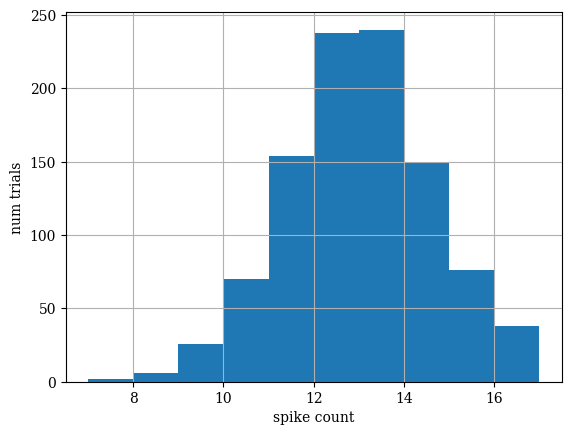

In [420]:
# (3)(c) (continued)
# save data to a separate variable so it doesn't accidentally get overwritten
spike_counts_3c = spike_counts
plt.hist(spike_counts_3c)
plt.xlabel("spike count")
plt.ylabel("num trials")
plt.grid()

In [421]:
# (3)(c) (continued)
M = np.mean(spike_counts_3c)
Var = np.var(spike_counts_3c)
print(f"Fano Factor for trials = {Var/M}")

Fano Factor for trials = 0.2192553905126976


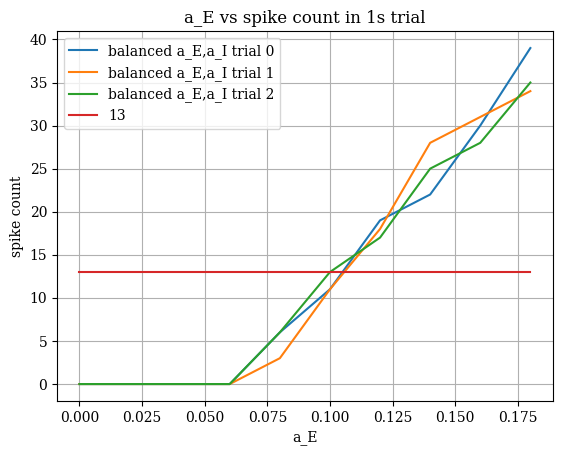

In [422]:
# (3)(d)
# The balance equation from (3)(b) gave:
# a_I = a_E * (36/42.5)
timescale = .0002
total_time = 1
steps = int(total_time/timescale)
timesteps = np.arange(0,total_time, timescale)

C = 1 # uF/cm^2
g_L = .1 # mS/cm^2
V_L = -65 # mV
V_T = -60 # mV 
V_reset = -70 # mV
V_peak = -45 # mV
delta = 2 # mV

a_E_vals = np.arange(0, .2, .02)
for trial in range(3):
    spike_counts = []
    for a_E in a_E_vals:
        I_E = Integrator(lam = 500, a = a_E, tau_1 = .004, tau_2 = .0004, firing_times = [])
        I_I = Integrator(lam = 500, a = a_E * (36/42.5), tau_1 = .006, tau_2 = .00175, firing_times = [])
        spikes = np.random.rand(timesteps.size) < 500*timescale

        spike_count = 0
        V = V_reset
        for idx, t in enumerate(timesteps):
            dV = 0
            I_net = 0
            if V > V_peak:
                spike_count += 1
                V = V_reset

            for I in [I_E, I_I]:
                I_net += I.current(t)
                if spikes[idx]:
                    I.firing_times.append(t)

            phi = g_L * delta * math.e ** ((V-V_T)/delta)
            dV = -g_L * (V - V_L) + phi + I_net

            V += dV * timescale * 1000

        spike_counts.append(spike_count)
    plt.plot(a_E_vals, spike_counts, label = f"balanced a_E,a_I trial {trial}")
plt.plot(a_E_vals, [13]*len(a_E_vals), label = "13")
plt.xlabel("a_E")
plt.ylabel("spike count")
plt.title("a_E vs spike count in 1s trial")
plt.grid()
plt.legend()

In [423]:
# (3)(d) (continued)
# a_I = a_E * (36/42.5)
# so using the above a_E = .102, a_I = .1 * (36/42.5)
timescale = .0002
total_time = 1
steps = int(total_time/timescale)
timesteps = np.arange(0,total_time, timescale)

C = 1 # uF/cm^2
g_L = .1 # mS/cm^2
V_L = -65 # mV
V_T = -60 # mV 
V_reset = -70 # mV
V_peak = -45 # mV
delta = 2 # mV

start=time.time()

spike_counts = []
a_E = .102

for trial in range(500):
    I_E = Integrator(lam = 500, a = a_E, tau_1 = .004, tau_2 = .0004, firing_times = [])
    I_I = Integrator(lam = 500, a = a_E * (36/42.5), tau_1 = .006, tau_2 = .00175, firing_times = [])
    spikes = np.random.rand(timesteps.size) < 500*timescale
    
    spike_count = 0
    V = V_reset
    for idx, t in enumerate(timesteps):
        dV = 0
        I_net = 0
        if V > V_peak:
            spike_count += 1
            V = V_reset

        for I in [I_E, I_I]:
            I_net += I.current(t)
            if spikes[idx]:
                I.firing_times.append(t)

        phi = g_L * delta * math.e ** ((V-V_T)/delta)
        dV = -g_L * (V - V_L) + phi + I_net

        V += dV * timescale * 1000

    spike_counts.append(spike_count)
    
    if trial % 50 == 0:
        print(f"Trial {trial} finished after {time.time()-start}s")


Trial 0 finished after 0.1687929630279541s
Trial 50 finished after 8.327632188796997s
Trial 100 finished after 16.815853118896484s
Trial 150 finished after 25.62076163291931s
Trial 200 finished after 34.385093450546265s
Trial 250 finished after 43.83734083175659s
Trial 300 finished after 54.051872968673706s
Trial 350 finished after 63.73470401763916s
Trial 400 finished after 73.20397400856018s
Trial 450 finished after 81.71547937393188s


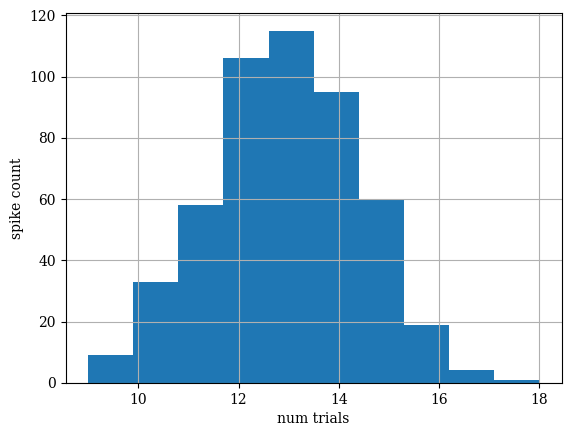

In [424]:
# (3)(d) (continued)
# save data to a separate variable so it doesn't accidentally get overwritten
spike_counts_3d = spike_counts
plt.hist(spike_counts_3d)
plt.ylabel("spike count")
plt.xlabel("num trials")
plt.grid()

In [425]:
# (3)(d) (continued)
M = np.mean(spike_counts_3d)
print(f"Mean for trials = {M}")
Var = np.var(spike_counts_3d)
print(f"Fano Factor for trials = {Var/M}")

Mean for trials = 12.872
Fano Factor for trials = 0.21221379738968302
